In [1]:
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.datasets import cifar10
from keras import layers, Input
import numpy as np
from keras.models import Sequential

# Local imports:
import sys
sys.path.append("../../Code")
from utils import show_train_history

2024-02-11 16:54:20.166111: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-11 16:54:20.186162: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-11 16:54:20.186181: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-11 16:54:20.186881: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-11 16:54:20.190743: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# Load the ResNet50 model
base_model = ResNet50(weights='imagenet', input_shape=(64, 64, 3), include_top=False)

# Remove the last layer from the base model
base_model.layers.pop()

# Create a Sequential model
model = Sequential()

# Add the ResNet50 base model to the Sequential model
model.add(base_model)

# Flatten the output of the ResNet50 model
model.add(layers.Flatten())

model.add(layers.Dense(256, activation='relu'))

# Add a Dense layer with 10 units (assuming 10 classes) and softmax activation
model.add(layers.Dense(10, activation='softmax'))

# Display the model summary
model.summary()

2024-02-11 16:54:21.060555: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-11 16:54:21.081197: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-11 16:54:21.081294: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                                 
Total params: 25687690 (97.99 MB)
Trainable params: 25634570 (97.79 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


In [3]:
from keras.utils import to_categorical

# Load the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Upsample the images to be 64x64:
x_train = np.array([image.array_to_img(x, scale=False).resize((64, 64)) for x in x_train])
x_test = np.array([image.array_to_img(x, scale=False).resize((64, 64)) for x in x_test])

# Preprocess the data
x_train = preprocess_input(x_train)
x_test = preprocess_input(x_test)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Train the model
# Adam with decay:
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
def schedule(epoch):
    if epoch < 5:
        return 0.001
    if epoch < 10:
        return 0.0003
    return 0.0001
optimizer = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, 
              metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=20, batch_size=128, validation_split=0.2,
                    callbacks=[LearningRateScheduler(schedule)])


Epoch 1/20


2024-02-11 16:54:32.764173: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-02-11 16:54:33.846065: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f70c8bf80a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-11 16:54:33.846079: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-02-11 16:54:33.849016: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1707688473.886865  496805 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


313/313 [==============================] - 31s 54ms/step - loss: 0.7919 - accuracy: 0.7475 - val_loss: 0.6972 - val_accuracy: 0.7694 - lr: 0.0010
Epoch 2/20
313/313 [==============================] - 13s 41ms/step - loss: 0.4406 - accuracy: 0.8547 - val_loss: 1.0662 - val_accuracy: 0.6909 - lr: 0.0010
Epoch 3/20
313/313 [==============================] - 13s 42ms/step - loss: 0.3872 - accuracy: 0.8690 - val_loss: 0.9959 - val_accuracy: 0.6930 - lr: 0.0010
Epoch 4/20
313/313 [==============================] - 13s 42ms/step - loss: 0.2794 - accuracy: 0.9056 - val_loss: 0.8023 - val_accuracy: 0.7704 - lr: 0.0010
Epoch 5/20
313/313 [==============================] - 13s 42ms/step - loss: 0.1956 - accuracy: 0.9340 - val_loss: 0.7334 - val_accuracy: 0.8018 - lr: 0.0010
Epoch 6/20
313/313 [==============================] - 13s 42ms/step - loss: 0.0540 - accuracy: 0.9818 - val_loss: 0.4356 - val_accuracy: 0.8903 - lr: 3.0000e-04
Epoch 7/20
313/313 [==============================] - 13s 42ms/st

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


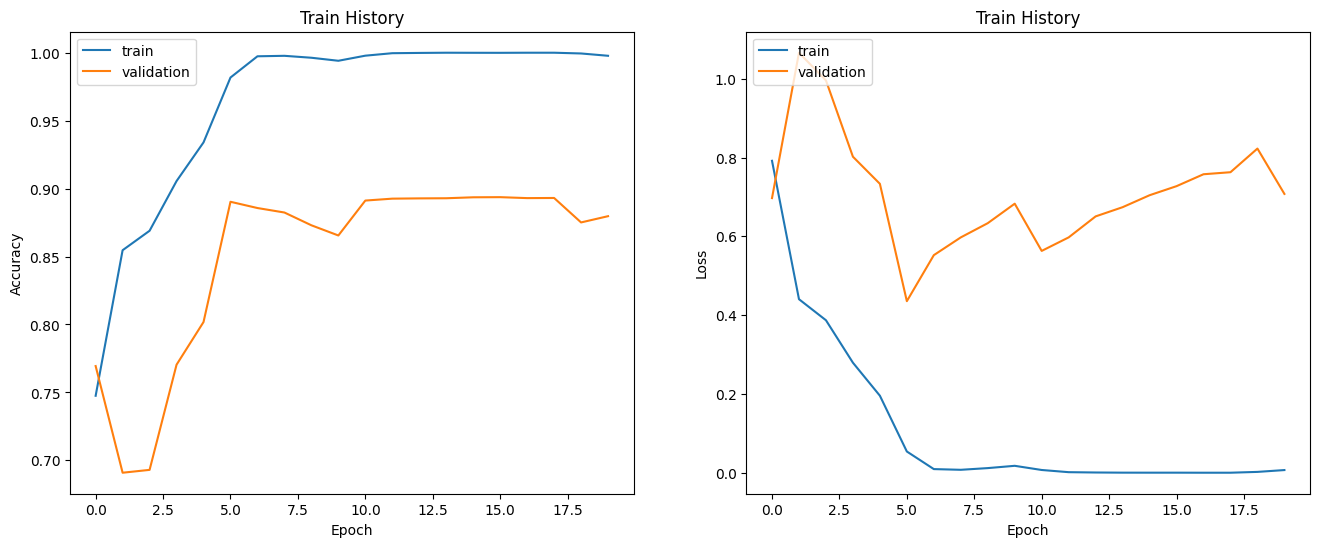

In [4]:
show_train_history(history)